## Debris Flow Prediction Using Machine Learning Based on Staley's 2016 Model

In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Import dataset

In [2]:
data = pd.read_csv('staley_data.csv')

In [3]:
# Load main dataset and labels
df = data[data.keys()[3:-1]]
labels = data[['Database','Response']]

# Create training and test datasets
X_train = df[df['Database'] == 'Training'].drop(['Database'],axis=1)
X_test = df[df['Database'] == 'Test'].drop(['Database'],axis=1)
y_train = labels[labels['Database'] == 'Training'].drop(['Database'],axis=1).values.ravel()
y_test = labels[labels['Database'] == 'Test'].drop(['Database'],axis=1).values.ravel()

#### Preprocessing

In [4]:
# Preprocessing for categorical data


In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance

# Categorical data
categorical_columns = ["State"]
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1)
numerical_pipe = SimpleImputer(strategy="mean")

# Preprocessing pipeline
preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, X_train.keys()[1:]),
    ],
    verbose_feature_names_out=False,
)


# Random Forest model
rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

# Fit RF
rf.set_params(classifier__min_samples_leaf=20).fit(X_train, y_train)

print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 0.898
RF test accuracy: 0.736


In [6]:
# # Feature importance
# result = permutation_importance(
#     rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
# )

# sorted_importances_idx = result.importances_mean.argsort()
# importances = pd.DataFrame(
#     result.importances[sorted_importances_idx].T,
#     columns=X_test.columns[sorted_importances_idx],
# )
# ax = importances.plot.box(vert=False, whis=10)
# ax.set_title("Permutation Importances (test set)")
# ax.axvline(x=0, color="k", linestyle="--")
# ax.set_xlabel("Decrease in accuracy score")
# ax.figure.tight_layout()

/Users/minho/opt/anaconda3/envs/burnseverity/lib/python3.10/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


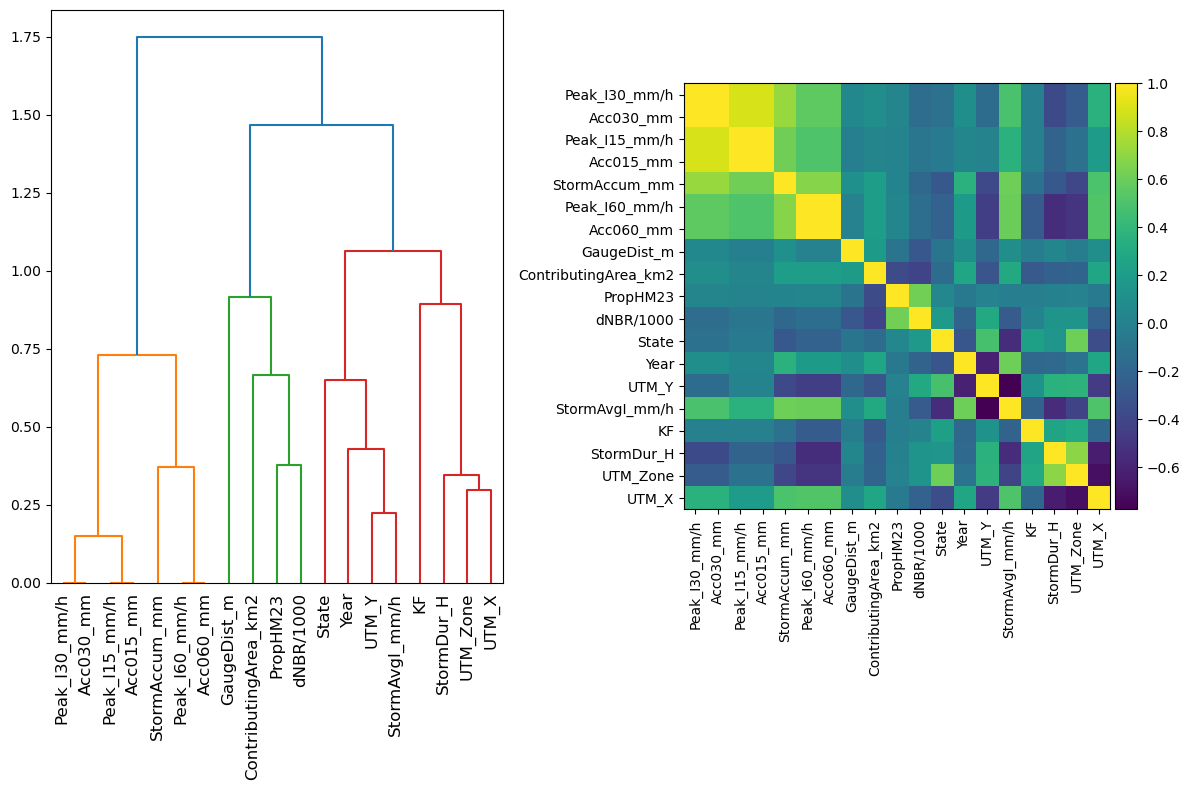

In [7]:
# Correlation matrix
# When features are collinear, permutating one feature will have little effect on the models performance because it can get the 
# same information from a correlated feature. One way to handle multicollinear features is by performing hierarchical clustering 
# on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster. 

from scipy.stats import spearmanr
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_test,nan_policy='omit').correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_test.columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

im = ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax2.legend()
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


fig.tight_layout()
plt.show()

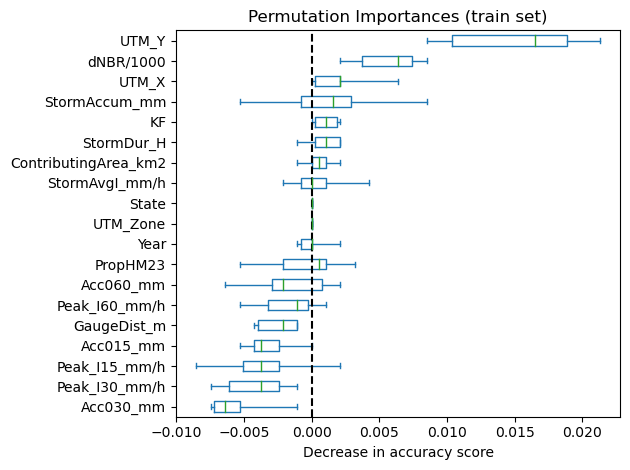

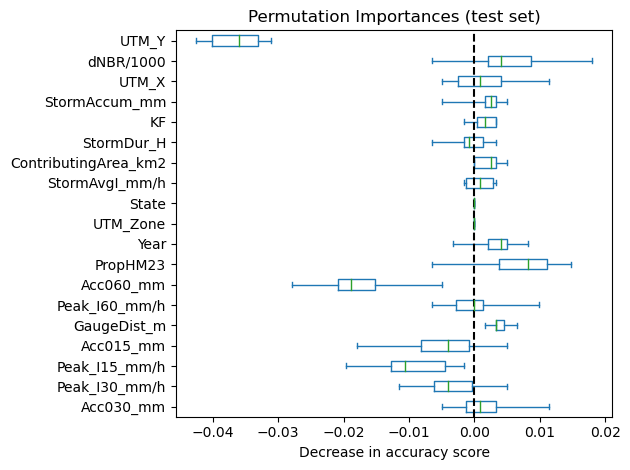

In [8]:
train_result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
test_results = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_importances_idx = train_result.importances_mean.argsort()

train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

#### SHAPLEY

In [9]:
# SHAPLEY
import shap
print(np.__version__)

shap_sample_size = int(df.shape[0] / 2)

# Load data (again) without categorical data
df = data[data.keys()[3:-1]]
labels = data[['Database','Response']]

# Create training and test datasets
X_train = df[df['Database'] == 'Training'].drop(['Database', 'State'],axis=1)[1:]
X_test = df[df['Database'] == 'Test'].drop(['Database', 'State'],axis=1)[1:]
y_train = labels[labels['Database'] == 'Training'].drop(['Database'],axis=1).values.ravel()
y_test = labels[labels['Database'] == 'Test'].drop(['Database'],axis=1).values.ravel()

# Initialize
shap.initjs()

# Take samples from dataset
X_sampled = pd.DataFrame(X_train).sample(shap_sample_size, random_state=42)

1.23.5


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [10]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=100, min_samples_leaf=20, random_state=42)
model.fit(X_train, y_train)

XGBoostError: [00:38:50] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/data/data.cc:455: Check failed: this->labels.Size() % this->num_row_ == 0 (1 vs. 0) : Incorrect size for labels.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001393256d5 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x00000001393bb36a xgboost::MetaInfo::SetInfoFromHost(xgboost::GenericParameter const&, xgboost::StringView, xgboost::Json) + 4282
  [bt] (2) 3   libxgboost.dylib                    0x00000001393ba1c2 xgboost::MetaInfo::SetInfo(xgboost::GenericParameter const&, xgboost::StringView, xgboost::StringView) + 146
  [bt] (3) 4   libxgboost.dylib                    0x000000013933bdb9 XGDMatrixSetInfoFromInterface + 233
  [bt] (4) 5   libffi.8.dylib                      0x000000010ded8a22 ffi_call_unix64 + 82
  [bt] (5) 6   ???                                 0x000000030ae70670 0x0 + 13067814512



In [ ]:

explainer = shap.TreeExplainer(model)

In [ ]:
shap_values = explainer.shap_values(np.array(X_sampled))